# Dimensionality Reduction Analysis

In [1]:
import matplotlib.pyplot as plt
import sklearn.manifold as slm
import numpy as np
import json

## Import and Process Data

In [2]:
# Import JSON file as dict
fileIn = 'face_serums_ingredients.json'
with open(fileIn, 'r') as txtIn:
    products = json.load(txtIn)

In [3]:
# Find all ingredients
ingAll = []
ratings = []
loves = []
for product in products:
    ingAll.extend(products[product]['ingredients'])
    ratings.append(products[product]['rating'])
    loves.append(products[product]['loves-count'])

# Find all unique ingredients
ingUnq, ingCnt = np.unique(np.array(ingAll, dtype=np.dtype('U150')), return_counts=True)
print('Number of products: ' + str(len(products)))
print('Max repeting ingredient: ' + str(np.max(ingCnt)))
print('Ingredience occuring once: ' + str(np.sum(ingCnt[ingCnt == 1])))
print('Number of different ingredients: ' + str(len(ingUnq)))

# Construct position to name conversions, ignore those occuring once
ii = 0
ptn = {}
minCnt = 5  # Minimum count of ingredients to store
for name, count in zip(ingUnq, ingCnt):
    if count >= minCnt:
        ptn[ii] = name
        ii += 1

# Name to position conversion
ntp = {name: position for position, name in ptn.items()}

# Create ingredients matrix
ingMat = np.zeros((len(products), len(ingUnq)))
for row, product in enumerate(products):
    ings = products[product]['ingredients']
    for ing in ings:
        ingPos = ntp.get(ing)  # if not fount None is returned
        if ingPos:
            ingMat[row, ingPos] = 1

Number of products: 407
Max repeting ingredient: 353
Ingredience occuring once: 1909
Number of different ingredients: 3246


## Manifold Learning Methods

In [4]:
numNeigh = 12        # Number of neighbours considered for analysis
numDim = 2           # Number of dimensions to reduce the data dimensionality to
useColour = ratings  # Use ratings / love-counts to colour the data

def add_feature_points(axis, points, colour, cmap='seismic', title=None):
    """Plot provided points as 2D scatter plot."""
    x, y = points[:, 0], points[:, 1]
    axis.scatter(x, y, c=colour, cmap=cmap)
    axis.set_title(title)

def plot_feature_points(points, colour, title=None):
    fig, axs = plt.subplots(figsize=(4, 4), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_feature_points(axs, points, colour)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

### Locally Linear Embeddings (LLE)
LLE are aking to applying local PCAs which are then compared globally.

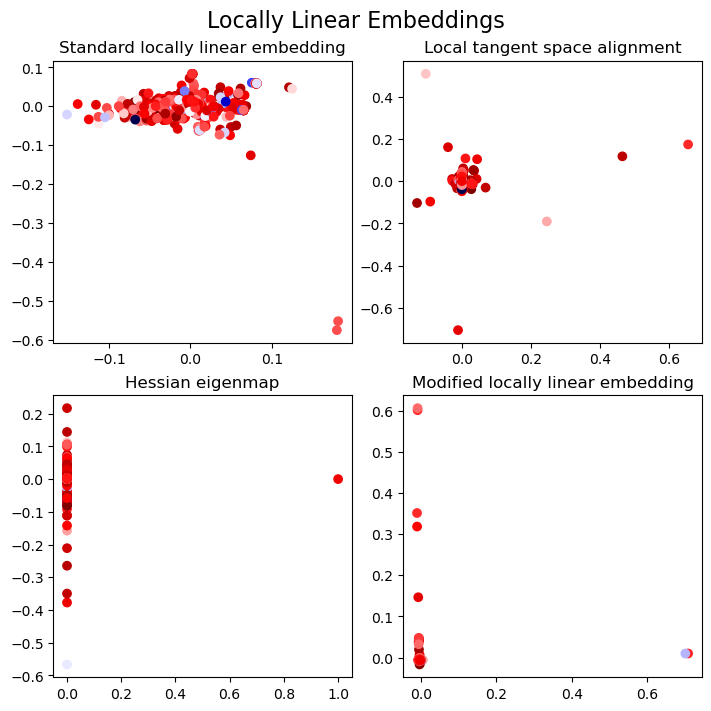

In [5]:
# Fit models
params = {
    "n_neighbors": numNeigh,
    "n_components": numDim,
    "eigen_solver": "auto",
    "random_state": 0,
    "eigen_solver": "dense",
}

lleStandard = slm.LocallyLinearEmbedding(method="standard", **params)
featLleStandard = lleStandard.fit_transform(ingMat)

lleLtsa = slm.LocallyLinearEmbedding(method="ltsa", **params)
featLleLtsa = lleLtsa.fit_transform(ingMat)

lleHessian = slm.LocallyLinearEmbedding(method="hessian", **params)
featLleHessian = lleHessian.fit_transform(ingMat)

lleMod = slm.LocallyLinearEmbedding(method="modified", **params)
featLleMod = lleMod.fit_transform(ingMat)

# Plot
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7), facecolor="white", constrained_layout=True)
fig.suptitle("Locally Linear Embeddings", size=16)

methods = [
    ("Standard locally linear embedding", featLleStandard),
    ("Local tangent space alignment", featLleLtsa),
    ("Hessian eigenmap", featLleHessian),
    ("Modified locally linear embedding", featLleMod),
]
for ax, method in zip(axs.flat, methods):
    name, points = method
    add_feature_points(ax, points, useColour, title=name)

plt.show()

### Isomap Embedding
Maintains geodesic distance between all points.

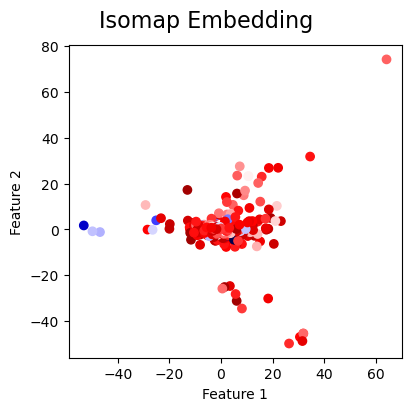

In [6]:
isoEmb = slm.Isomap(n_neighbors=numNeigh, n_components=numDim, p=1)
featIsoMap = isoEmb.fit_transform(ingMat)
plot_feature_points(featIsoMap, useColour, title='Isomap Embedding')

### Multidimensional Scaling (MDS)
Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

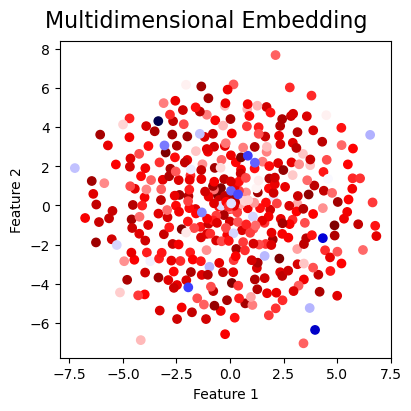

In [7]:
multiEmb = slm.MDS(n_components=numDim, max_iter=50, n_init=4, random_state=52, normalized_stress=False)
featMultiDim = multiEmb.fit_transform(ingMat)
plot_feature_points(featMultiDim, useColour, title='Multidimensional Embedding')

### T-Distributed Stochastic Neighbor Embedding
It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

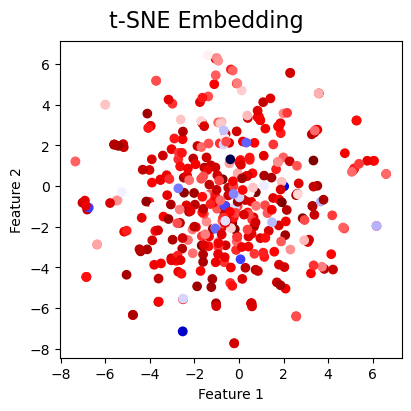

In [8]:
tsneEmb = slm.TSNE(n_components=2, random_state=52, perplexity=50, early_exaggeration=30)
featTsneEmb = tsneEmb.fit_transform(ingMat)
plot_feature_points(featTsneEmb, useColour, title='t-SNE Embedding')

### Spectral Embedding
This implementation uses Laplacian Eigenmaps, which finds a low dimensional representation of the data using a spectral decomposition of the graph Laplacian.

/opt/anaconda3/envs/cosml/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


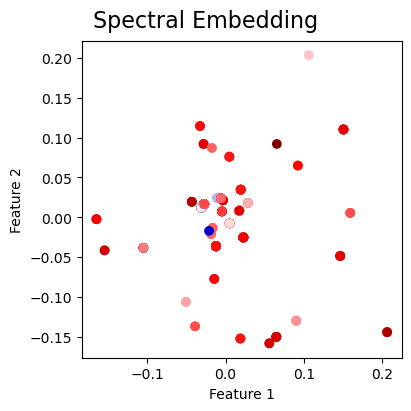

In [9]:
specEmb = slm.SpectralEmbedding(n_components=numDim, n_neighbors=numDim)
featSpecEmb = specEmb.fit_transform(ingMat)
plot_feature_points(featSpecEmb, useColour, title='Spectral Embedding')